## EAST (An Efficient and Accurate Scene Text Detector)

Text detection approach. The pipeline directly predicts words or text lines of arbitrary orientations and quadrilateral shapes in full images, eliminating unnecessary intermediate steps (e.g., candidate aggregation and word partitioning), with a single neural network. The simplicity of the pipeline allows concentrating efforts on designing loss functions and neural network architecture.
- Paper: https://arxiv.org/abs/1704.03155v2
- Github: https://github.com/argman/EAST 

[NOTE] jika ada error, berarti model belum di download. download model `model.ckpt-49491.data-00000-of-00001` dari https://drive.google.com/file/d/0B3APw5BZJ67ETHNPaU9xUkVoV0U/view dan letakkan pada folder `east_icdar2015_resnet_v1_50_rbox`

In [1]:
import os
import operator

import time
import datetime
import cv2
import numpy as np
import uuid
import json

import functools
import logging
import collections

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

logger.info('loading model')
import tensorflow as tf
from east import model
from east.icdar import restore_rectangle
from east import lanms
from east.eval import resize_image, sort_poly, detect
 
checkpoint_path = "east_icdar2015_resnet_v1_50_rbox/"

input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')

global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
f_score, f_geometry = model.model(input_images, is_training=False)
variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
saver = tf.train.Saver(variable_averages.variables_to_restore())

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.65
sess = tf.Session(config=config)

ckpt_state = tf.train.get_checkpoint_state(checkpoint_path)
model_path = os.path.join(checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
logger.info('Restore from {}'.format(model_path))
saver.restore(sess, model_path)


@functools.lru_cache(maxsize=1)
def get_host_info():
    ret = {}
    with open('/proc/cpuinfo') as f:
        ret['cpuinfo'] = f.read()

    with open('/proc/meminfo') as f:
        ret['meminfo'] = f.read()

    with open('/proc/loadavg') as f:
        ret['loadavg'] = f.read()

    return ret


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, color=(255, 0, 255))
    return illu

def predictor(img):
    start_time = time.time()
    rtparams = collections.OrderedDict()
    rtparams['start_time'] = datetime.datetime.now().isoformat()
    rtparams['image_size'] = '{}x{}'.format(img.shape[1], img.shape[0])
    timer = collections.OrderedDict([
        ('net', 0),
        ('restore', 0),
        ('nms', 0)
    ])

    im_resized, (ratio_h, ratio_w) = resize_image(img)
    rtparams['working_size'] = '{}x{}'.format(
        im_resized.shape[1], im_resized.shape[0])
    start = time.time()
    score, geometry = sess.run(
        [f_score, f_geometry],
        feed_dict={input_images: [im_resized[:,:,::-1]]})
    timer['net'] = time.time() - start

    boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
    logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
        timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

    if boxes is not None:
        scores = boxes[:,8].reshape(-1)
        boxes = boxes[:, :8].reshape((-1, 4, 2))
        boxes[:, :, 0] /= ratio_w
        boxes[:, :, 1] /= ratio_h

    duration = time.time() - start_time
    timer['overall'] = duration
    logger.info('[timing] {}'.format(duration))

    text_lines = []
    if boxes is not None:
        text_lines = []
        for box, score in zip(boxes, scores):
            box = sort_poly(box.astype(np.int32))
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                continue
            tl = collections.OrderedDict(zip(
                ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                map(float, box.flatten())))
            tl['score'] = float(score)
            text_lines.append(tl)
    ret = {
        'text_lines': text_lines,
        'rtparams': rtparams,
        'timing': timer,
    }
    ret.update(get_host_info())
    return ret

resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491


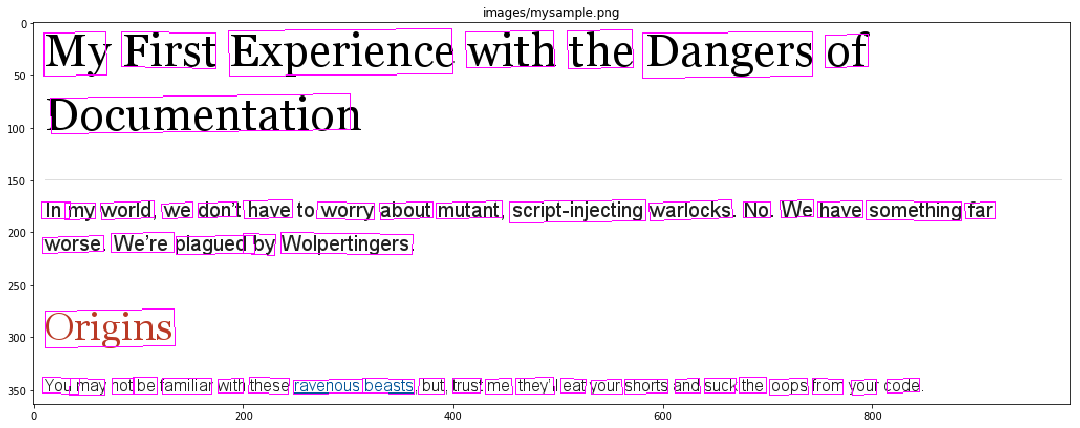

In [2]:
import matplotlib.pyplot as plt

def get_boxes_east(rst) :
    bbox = []
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        min_x = min(d[0][0], d[3][0])
        min_y = min(d[0][1], d[1][1])
        max_x = max(d[1][0], d[2][0])
        max_y = max(d[2][1], d[3][1])
        if min_x >= 0 and min_y >= 0 and max_x >= 0 and max_y >= 0 :
            bbox.append([min_x, min_y, max_x, max_y])
        
    return bbox

im_name = "images/mysample.png"
# im_name = "images/check.png"
# im_name = "images/street1.jpg"

img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rst = predictor(img)
bbox = get_boxes_east(rst)
img = draw_illu(img, rst)
fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(im_name)
plt.imshow(img)

/home/mhilmiasyrofi/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


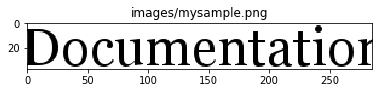

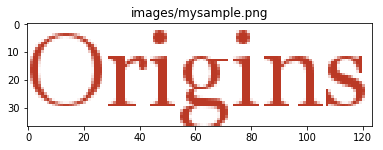

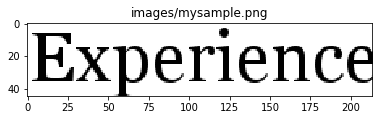

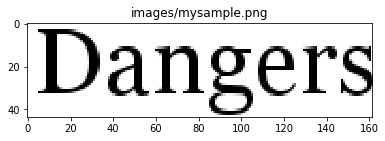

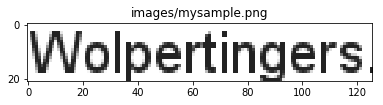

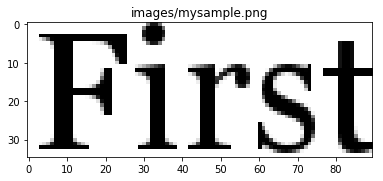

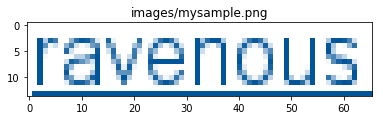

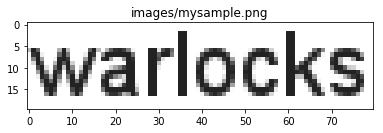

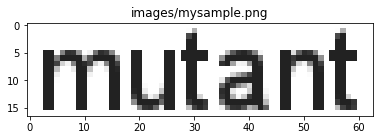

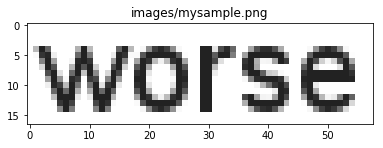

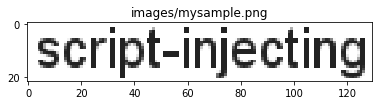

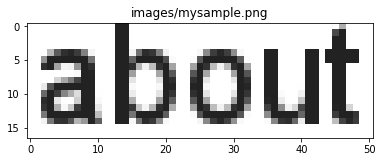

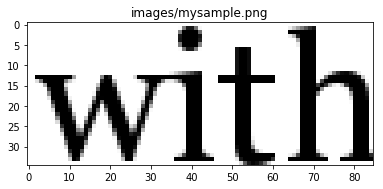

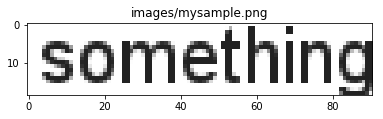

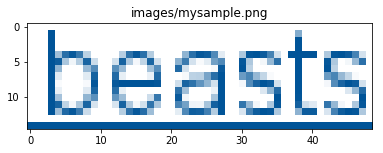

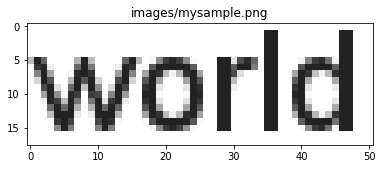

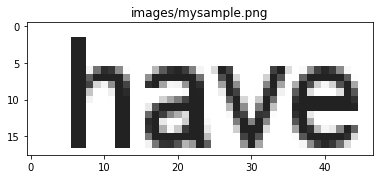

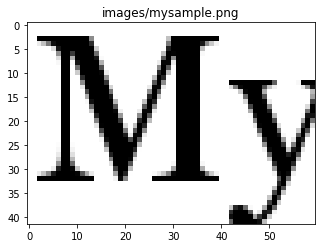

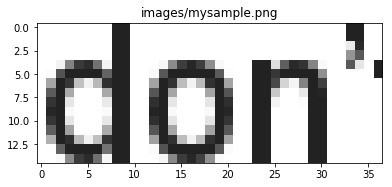

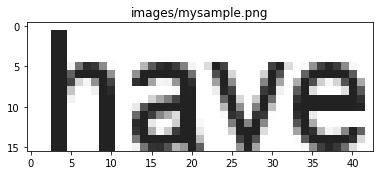

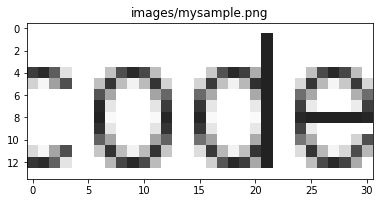

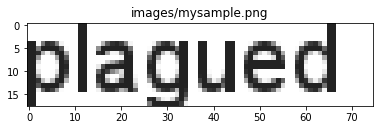

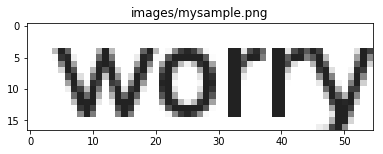

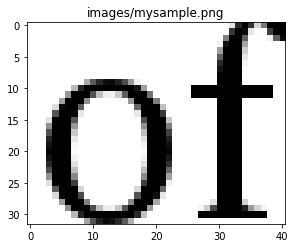

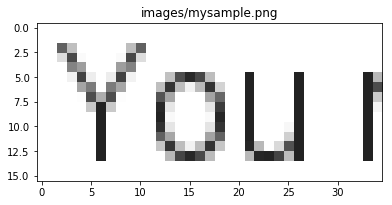

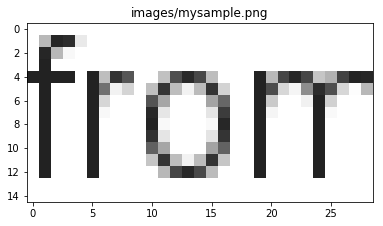

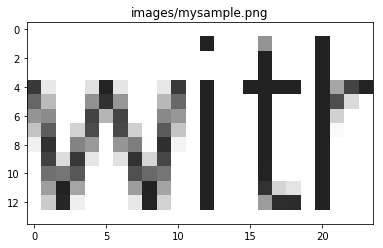

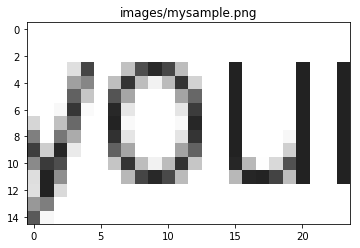

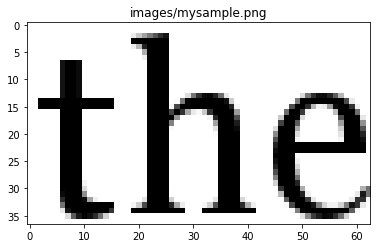

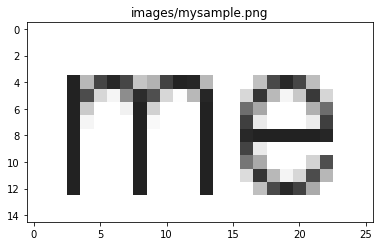

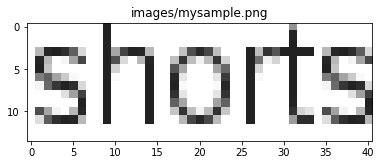

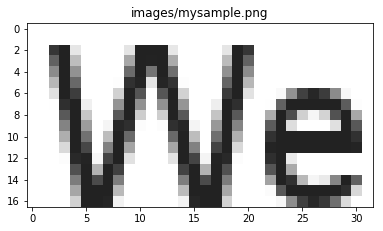

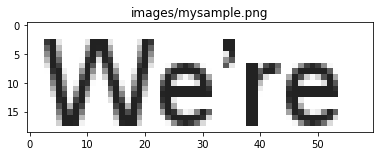

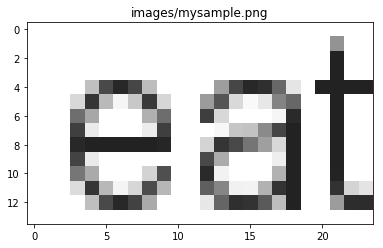

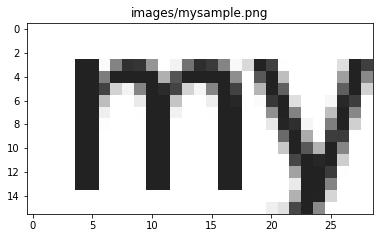

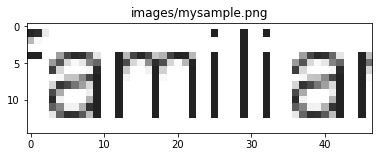

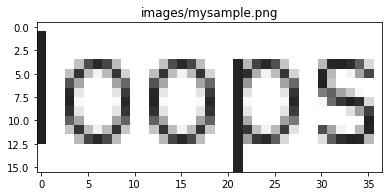

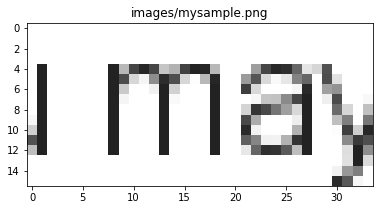

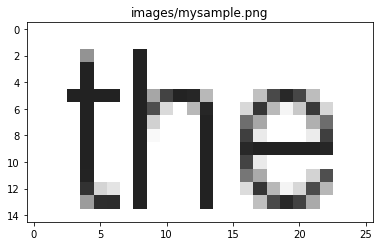

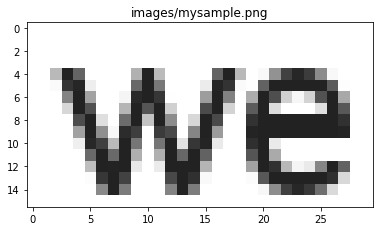

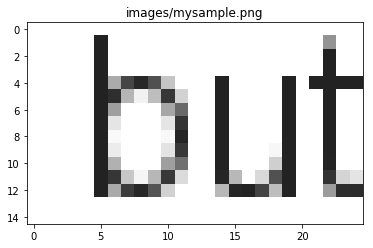

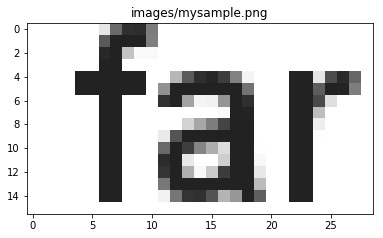

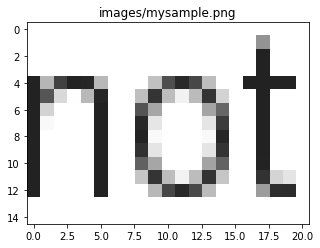

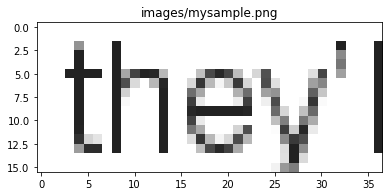

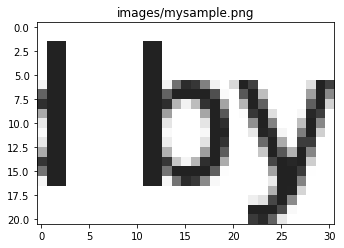

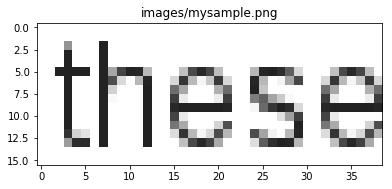

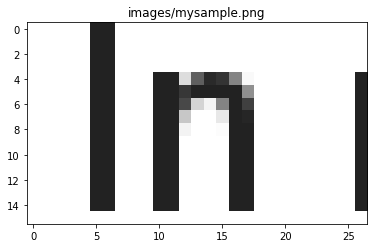

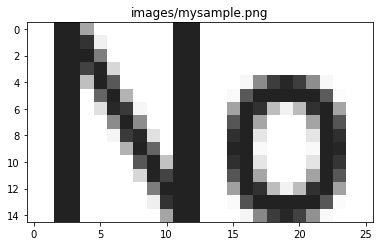

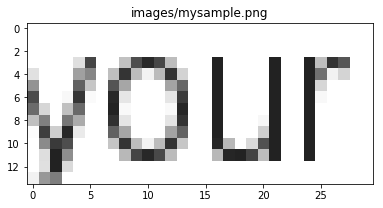

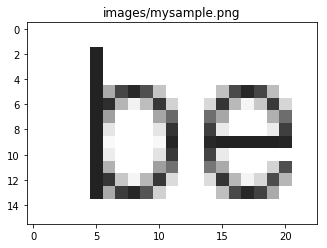

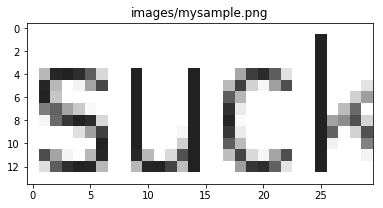

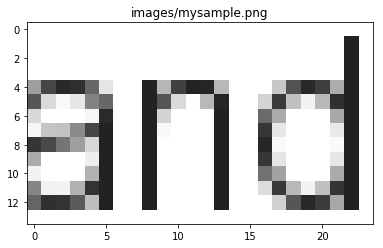

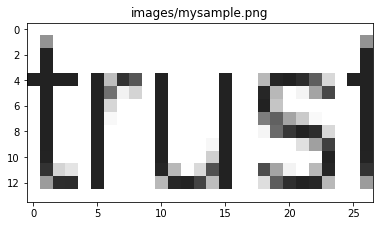

In [3]:
imgs = []
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)
    
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(im_name)
    plt.imshow(crop_img)

## Bounding Box analsys untuk mendapatkan sekumpulan kata

In [4]:
# print(bbox)

class BoundingBox:
    x1 = 0
    x2 = 0
    y1 = 0
    y2 = 0
    width = 0
    height = 0
    
    def __init__(self, x1, x2, y1, y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.width = self.y2 - self.y1
        self.height = self.x2 - self.x1
        
    def __str__(self):
        return "" + str(self.x1) + ", " + str(self.x2) + ", " + str(self.y1) + ", " + str(self.y2) + ", " + str(self.width) + ", " + str(self.height) + "\n"

In [5]:
data = []
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    box = BoundingBox(x1, x2, y1, y2)
    data.append(box)
    
data.sort(key = operator.attrgetter("x1")) 

# for d in data:
#     print(d)

In [6]:
sentences = []
sentence = []
threshold = 0
if len(data) > 0 :
    sentence.append(data[0])
    upper_threshold = data[0].x1
    lower_threshold = data[0].x2
    interval_threshold = data[0].height/2
    for i in range(1, len(data)):
        if abs(data[i].x1 - upper_threshold) < interval_threshold or abs(data[i].x2 - lower_threshold) < interval_threshold :
            sentence.append(data[i])
        else:
            sentences.append(sentence)
            sentence = []
            upper_threshold = data[i].x1
            lower_threshold = data[i].x2
            interval_threshold = data[i].height/2
            sentence.append(data[i])
    sentences.append(sentence)
            
# for s in sentences:
#     for k in s:
#         print(k)
#     print()
#     print()

In [7]:
## urutin sesuai Y
for s in sentences:
    s.sort(key = operator.attrgetter("y1")) 

    
## gabungin jika masih sesuai
idx = []
for i in range(1, len(sentences)):
    if abs(sentences[i-1][0].height - sentences[i][0].height) < sentences[i][0].height / 3 : ## and abs(sentences[i-1][0].x2 - sentences[i][0].x1) < sentences[i-1][0].height :
        idx.append(i)


count = 0
for i in idx :
    for s in sentences[i-count]:
        sentences[i-1-count].append(s)
    del sentences[i-count]
    count += 1

# for s in sentences:
#     for k in s:
#         print(k)
#     print()
#     print()

## (SEE) Semi-Supervised End-to-End Scene Text Recognition¶

In [8]:
import argparse
import importlib

import os

import json
from collections import OrderedDict

import chainer
from pprint import pprint

import chainer.functions as F
import numpy as np

from PIL import Image
from chainer import configuration

from see.chainer.utils.datatypes import Size

from see.chainer import functions


def get_class_and_module(log_data):
    if not isinstance(log_data, list):
        if 'InverseCompositional' in log_data:
            module_name = 'ic_stn.py'
            klass_name = log_data
        else:
            module_name = 'text_recognition.py'
            klass_name = log_data
    else:
        klass_name, module_name = log_data
    return klass_name, module_name


def load_module(module_file):
    module_spec = importlib.util.spec_from_file_location("models.model", module_file)
    module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(module)
    return module


def build_recognition_net(recognition_net_class, target_shape, args):
    return recognition_net_class(
        target_shape,
        num_rois=args.timesteps,
        label_size=52,
    )


def build_localization_net(localization_net_class, target_shape, args):
    return localization_net_class(
        args.dropout_ratio,
        args.timesteps,
        0,
        target_shape,
        zoom=1.0,
        do_parameter_refinement=False
    )


def build_fusion_net(fusion_net_class, localization_net, recognition_net):
    return fusion_net_class(localization_net, recognition_net)


def create_network(args, log_data):
    # Step 1: build network
    localization_net_class_name, localization_module_name = get_class_and_module(log_data['localization_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, localization_module_name)))
    localization_net_class = eval('module.{}'.format(localization_net_class_name))
    localization_net = build_localization_net(localization_net_class, log_data['target_size'], args)

    recognition_net_class_name, recognition_module_name = get_class_and_module(log_data['recognition_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, recognition_module_name)))
    recognition_net_class = eval('module.{}'.format(recognition_net_class_name))
    recognition_net = build_recognition_net(recognition_net_class, target_shape, args)

    fusion_net_class_name, fusion_module_name = get_class_and_module(log_data['fusion_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, fusion_module_name)))
    fusion_net_class = eval('module.{}'.format(fusion_net_class_name))
    net = build_fusion_net(fusion_net_class, localization_net, recognition_net)

    if args.gpu >= 0:
        net.to_gpu(args.gpu)

    return net


def load_image(image_file, xp, image_size):
    with Image.open(image_file) as the_image:
        the_image = the_image.convert('L')
        the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
        image = xp.asarray(the_image, dtype=np.float32)
        image /= 255
        image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
        return image

def preprocess_image(the_image, xp, image_size) :
    the_image = the_image.convert('L')
    the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
    image = xp.asarray(the_image, dtype=np.float32)
    image /= 255
    image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
    return image

def strip_prediction(predictions, xp, blank_symbol):
    words = []
    for prediction in predictions:
        blank_symbol_seen = False
        stripped_prediction = xp.full((1,), prediction[0], dtype=xp.int32)
        for char in prediction:
            if char == blank_symbol:
                blank_symbol_seen = True
                continue
            if char == stripped_prediction[-1] and not blank_symbol_seen:
                continue
            blank_symbol_seen = False
            stripped_prediction = xp.hstack((stripped_prediction, char.reshape(1, )))
        words.append(stripped_prediction)
    return words


def extract_bbox(bbox, image_size, target_shape, xp):
    bbox.data[...] = (bbox.data[...] + 1) / 2
    bbox.data[0, :] *= image_size.width
    bbox.data[1, :] *= image_size.height

    x = xp.clip(bbox.data[0, :].reshape(target_shape), 0, image_size.width)
    y = xp.clip(bbox.data[1, :].reshape(target_shape), 0, image_size.height)

    top_left = (float(x[0, 0]), float(y[0, 0]))
    bottom_right = (float(x[-1, -1]), float(y[-1, -1]))

    return top_left, bottom_right

In [9]:
args = argparse.ArgumentParser(description="Tool that loads model and predicts on a given image")
args.model_dir = "see/chainer/text_recognition_model/model"
args.snapshot_name = "model_190000.npz"
args.image_path = im_name
args.char_map = "see/chainer/text_recognition_model/small_dataset/ctc_char_map.json"
args.log_name = 'log'
args.dropout_ratio = 0.5
args.blank_symbol = 0
args.gpu = -1
# max number of text regions in the image
args.timesteps = 23
# max number of characters per word
args.num_labels = 1

# open log and extract meta information
with open(os.path.join(args.model_dir, args.log_name)) as the_log:
    log_data = json.load(the_log)[0]

target_shape = Size._make(log_data['target_size'])
image_size = Size._make(log_data['image_size'])

xp = chainer.cuda.cupy if args.gpu >= 0 else np
network = create_network(args, log_data)

# load weights
with np.load(os.path.join(args.model_dir, args.snapshot_name)) as f:
    chainer.serializers.NpzDeserializer(f).load(network)

# load char map
with open(args.char_map) as the_map:
    char_map = json.load(the_map)

# load image
image = load_image(args.image_path, xp, image_size)
with configuration.using_config('train', False):
    predictions, crops, grids = network(image[xp.newaxis, ...])

# extract class scores for each word
words = OrderedDict({})

predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

classification = F.softmax(predictions, axis=2)
classification = classification.data
classification = xp.argmax(classification, axis=2)
classification = xp.transpose(classification, (1, 0))

word = strip_prediction(classification, xp, args.blank_symbol)[0]

word = "".join(map(lambda x: chr(char_map[str(x)]), word))

print(word)

def predict_see(image) :
    image = Image.fromarray(image)
    image = preprocess_image(image, xp, image_size)
    with configuration.using_config('train', False):
        predictions, crops, grids = network(image[xp.newaxis, ...])

    predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

    classification = F.softmax(predictions, axis=2)
    classification = classification.data
    classification = xp.argmax(classification, axis=2)
    classification = xp.transpose(classification, (1, 0))

    word = strip_prediction(classification, xp, args.blank_symbol)[0]

    word = "".join(map(lambda x: chr(char_map[str(x)]), word))

    return word

som


### Predict

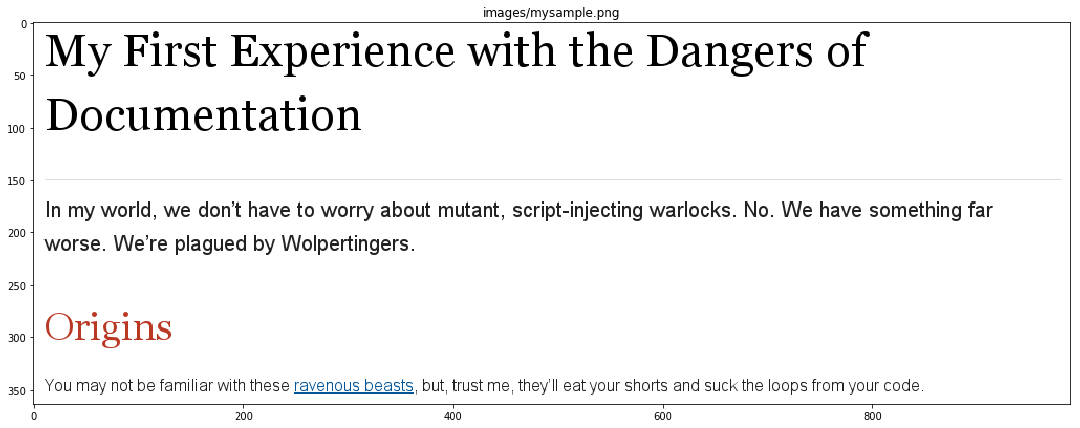

In [10]:
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(im_name)
plt.imshow(img)

document_img = [[]]
sentence_img = []

for s in sentences:
    for k in s:
        crop_img = img[k.x1:k.x2, k.y1:k.y2]
        sentence_img.append(crop_img)
    document_img.append(sentence_img)
    sentence_img = []

In [11]:
import matplotlib.pyplot as plt

result = []
kalimat = ""

for s in document_img:
    for i in s:
        kalimat += predict_see(i) + " "
    result.append(kalimat)
    kalimat = ""
    
print(result)

['', 'mu first experience with the dangers o documentatior ', "in my world we don' have wory about mutant script-injecting warlocks no ve have something far worse we'r plagued dby wolpertingers ", 'origins ', "you  ima not be jamiliar mit these ravenous beasts bout trus me they' eat your shorts and suck the ops from jou code "]
